In [1]:
# coding:utf-8
import numpy as np
import scipy.io as scio
import cv2
import math
import random
import scipy.io as scio
import math
import os
import alphashape
from shapely.geometry import mapping

def getRedConnectedAndBorder(rc):
    ret, thresh = cv2.threshold(rc, 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    h, w = rc.shape
    cat_map = np.zeros((h, w), dtype=np.uint8)
    box_list = []
    cat_list = []
    cat = 1
    for i in range(len(contours)):
        cnt = contours[i]
        # filter noisy area
        if len(cnt) < 4:
            continue
        rect = cv2.minAreaRect(cnt)
        area = cv2.contourArea(cnt)
        #if area <= 10:
        #    continue
        if rect[1][0] * rect[1][1] < 100:
            continue
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        box_list.append(box)
        # get simple border
        epsilon = 0.005 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        cv2.drawContours(cat_map, [approx], -1, cat, -1)
        cat_list.append(cat)
        cat += 1
    return cat_map, box_list, cat_list

def findSamplePoints(skeleton, box, cat, pointNumber):
    box = np.array(box, dtype=np.int32)
    h, w = skeleton.shape
    edge1 = np.linalg.norm(box[0]-box[1])
    edeg2 = np.linalg.norm(box[1]-box[2])
    if edge1<edeg2:
        start1 = box[1]
        start2 = box[0]
        vector1 = box[2]-box[1]
        vector2 = box[3]-box[0]
    else:
        start1 = box[0]
        start2 = box[3]
        vector1 = box[1]-box[0]
        vector2 = box[2]-box[3]
    # set the number of sample points
    interval = pointNumber
    selectedPoints = []
    for i in range(interval+1):
        blank = np.zeros((h, w), dtype=np.uint8)
        p1 = list(map(int, start1+vector1*1.0*i/interval))
        p2 = list(map(int, start2+vector2*1.0*i/interval))
        cv2.line(blank, (p1[0], p1[1]), (p2[0], p2[1]), 100, 1)
        skeleton_temp = skeleton+blank
        r_list, c_list = np.where(skeleton_temp==cat+100)
        if len(r_list) == 0 or len(c_list) == 0:
            if i < interval/2:
                for j in range(1, 10, 1):
                    p1 = list(map(int, start1 + vector1 * 1.0 * i / interval +
                             vector1*1.0*j/np.linalg.norm(np.array(vector1, dtype=np.float32))))
                    p2 = list(map(int, start2 + vector2 * 1.0 * i / interval +
                             vector2 * 1.0 * j / np.linalg.norm(np.array(vector2, dtype=np.float32))))
                    cv2.line(blank, (p1[0], p1[1]), (p2[0], p2[1]), 100, 1)
                    skeleton_temp = skeleton + blank
                    r_list, c_list = np.where(skeleton_temp == cat + 100)
                    if len(r_list) != 0:
                        break
            else:
                for j in range(1, 10, 1):
                    p1 = list(map(int, start1 + vector1 * 1.0 * i / interval -
                             vector1 * 1.0 * j / np.linalg.norm(np.array(vector1, dtype=np.float32))))
                    p2 = list(map(int, start2 + vector2 * 1.0 * i / interval -
                             vector2 * 1.0 * j / np.linalg.norm(np.array(vector2, dtype=np.float32))))
                    cv2.line(blank, (p1[0], p1[1]), (p2[0], p2[1]), 100, 1)
                    skeleton_temp = skeleton + blank
                    r_list, c_list = np.where(skeleton_temp == cat + 100)
                    if len(r_list)!=0:
                        break
        if len(r_list)==0:
            print ('file :{} ,middle point {} loss'.format(f, i+1))
            continue
        selectedPoints.append([np.mean(r_list), np.mean(c_list)])
    return selectedPoints

def drawContour(skeleton, selectedPoints, dir_maps):
    # 0 up, 1 up-right, 2 right, 3 right-down, 4 down, 5 left-down, 6 left, 7 left-up
    # threshold : filter the long distance
    allContourPoints = []
    allPointsDis = []
    for cords in selectedPoints:
        perContourPoints = []
        perPointsDis = []
        [r, c] = map(int, cords)
        h, w = skeleton.shape
        threshold = 1e6
        if dir_maps[r][c][0] < threshold:
            newr = np.clip(r - int(dir_maps[r][c][0]), 0, h - 1)
            newc = np.clip(c, 0, w - 1)
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][0])
        if dir_maps[r][c][1] < threshold:
            newr = np.clip(r - int(dir_maps[r][c][1] * math.sqrt(2) / 2.), 0, h - 1)
            newc = np.clip(c + int(dir_maps[r][c][1] * math.sqrt(2) / 2.), 0, w - 1)
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][1])
        if dir_maps[r][c][2] < threshold:
            newr = r
            newc = np.clip(c + int(dir_maps[r][c][2]), 0, w - 1)
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][2])
        if dir_maps[r][c][3] < threshold:
            newr = np.clip(r + int(dir_maps[r][c][3] * math.sqrt(2) / 2.), 0, h - 1)
            newc = np.clip(c + int(dir_maps[r][c][3] * math.sqrt(2) / 2.), 0, w - 1)
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][3])
        if dir_maps[r][c][4] < threshold:
            newr = np.clip(r + int(dir_maps[r][c][4]), 0, h - 1)
            newc = c
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][4])
        if dir_maps[r][c][5] < threshold:
            newr = np.clip(r + int(dir_maps[r][c][5] * math.sqrt(2) / 2.), 0, h - 1)
            newc = np.clip(c - int(dir_maps[r][c][5] * math.sqrt(2) / 2.), 0, w - 1)
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][5])
        if dir_maps[r][c][6] < threshold:
            newr = r
            newc = np.clip(c - int(dir_maps[r][c][6]), 0, w - 1)
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][6])
        if dir_maps[r][c][7] < threshold:
            newr = np.clip(r - int(dir_maps[r][c][7] * math.sqrt(2) / 2.), 0, h - 1)
            newc = np.clip(c - int(dir_maps[r][c][7] * math.sqrt(2) / 2.), 0, w - 1)
            perContourPoints.append([newr, newc])
            perPointsDis.append(dir_maps[r][c][7])
        allContourPoints.append(perContourPoints)
        allPointsDis.append(perPointsDis)
    return allContourPoints, allPointsDis

In [2]:
def getIntersectionPoint(p_s,p_e,map_w,map_h):
    intersection_points = []
    x_s = p_s[1]
    y_s = p_s[0]
    x_e = p_e[1]
    y_e = p_e[0]
    if x_s==x_e:
        intersection_points = [[x_s,0], [x_s,map_h]]
    elif y_s==y_e:
        intersection_points = [[0,y_s], [map_w,y_s]]
    else:
        # left border: x = 0
        x_left = 0
        y_left = (y_s-y_e)/(x_e-x_s)*x_s + y_s
        if y_left >= 0 and y_left <= map_h:
            intersection_points.append([x_left, y_left])
            
        # up border: y = 0
        y_up = 0
        x_up = (x_s - x_e)/(y_e - y_s)*y_s + x_s
        if x_up >=0 and x_up <= map_w:
            intersection_points.append([x_up, y_up])
            
        # right border: x = map_w
        x_right = map_w
        y_right = (y_e - y_s) / (x_e - x_s)*(map_w - x_s) + y_s
        if y_right >= 0 and y_right <= map_h:
            intersection_points.append([x_right, y_right])
            
        # down dorder: y = map_h
        y_down = map_h
        x_down = (x_e - x_s)/(y_e - y_s)*(map_h - y_s) + x_s
        if x_down >=0 and x_down <= map_w:
            intersection_points.append([x_down, y_down])        
        
    assert len(intersection_points) == 2
    intersection_point = []
    for p in intersection_points:
        dis_s = (p[0]-x_s)*(p[0]-x_s) + (p[1]-y_s)*(p[1]-y_s)
        dis_e = (p[0]-x_e)*(p[0]-x_e) + (p[1]-y_e)*(p[1]-y_e)
        if dis_s > dis_e:
            intersection_point = p
            break
    assert len(intersection_point)
    
    return intersection_point

In [3]:
def judgeReachable(border1, border2):
    if border2%2 == 0 and ( abs(border2 - border1) <=2 or abs(border2 - border1) >=6):
        return True
    elif border2%2 == 1 and (abs(border2 - border1) <=1 or abs(border2 - border1) >=7):
        return True
    else:
        return False

def getBorderID(point, map_h, map_w):
    x = point[0]
    y = point[1]
    if x==0 and y == 0:
        return 0
    elif x>0 and x<map_w and y ==0:
        return 1
    elif x==map_w and y==0:
        return 2
    elif x==map_w and y>0 and y<map_h:
        return 3
    elif x==map_w and y==map_h:
        return 4
    elif x>0 and x<map_w and y==map_h:
        return 5
    elif x==0 and y==map_h:
        return 6
    elif x==0 and y>0 and y<map_h:
        return 7
    else:
        return -1

In [4]:
def getPolyArea(p1, p2, map_h, map_w, samplePoints):
    polyArea=[]
    for p in samplePoints:
        polyArea.append([p[1],p[0]])
    polyArea.append(p2)
    vertexList = [[0,0],[map_w, 0],[map_w,map_h],[0,map_h]]
    border1 = getBorderID(p1, map_h, map_w)
    border2 = getBorderID(p2, map_h, map_w)
    while not judgeReachable(border1, border2):
        border2 = ((border2+2) - (border2%2))%8
        polyArea.append(vertexList[int(border2/2)])
    polyArea.append(p1)
    return polyArea
        

In [5]:
def getOutputPolyPoints(samplePoints, borderPoints, pointsDis, map_h, map_w, ratio_h, ratio_w):
    p0 = samplePoints[0]
    p1 = samplePoints[1]
    p2 = samplePoints[-2]
    p3 = samplePoints[-1]
    intersectionP1 = getIntersectionPoint(p1,p0,map_w,map_h)
    intersectionP2 = getIntersectionPoint(p2,p3,map_w,map_h) 
    if intersectionP1 == intersectionP2:
        return []
    polyArea = getPolyArea(intersectionP1, intersectionP2, map_h, map_w, samplePoints)
    polyAreaArray = np.asarray(polyArea)
    canvas = np.zeros((map_h, map_w),dtype = np.uint8)
    canvasMask = np.zeros((map_h, map_w),dtype = np.uint8)
    for p in borderPoints:
        for pp in p:
            canvas[pp[0],pp[1]] = 1
    
    cv2.fillPoly(canvasMask, polyAreaArray.astype(np.int32)[np.newaxis, :, :], 2, lineType=4)
    canvas = canvas + canvasMask
    [points_r, points_c] = np.where(canvas == 3)
    points_dis = np.empty(points_r.shape, dtype=np.float32)
    for i in range(points_dis.size):
        points_dis[i] = np.sqrt(np.power(points_r[i] - p0[0],2) + np.power(points_c[i] - p0[1],2))
        
    pointsIndex = np.argsort(points_dis)
    
    points_r = points_r[pointsIndex]
    points_c = points_c[pointsIndex]
    
    outputPolyPointsSet1 = np.hstack((points_r[:,np.newaxis], points_c[:,np.newaxis]))
    

    [points_r, points_c] = np.where(canvas == 1)
    points_dis = np.empty(points_r.shape, dtype=np.float32)
    for i in range(points_dis.size):
        points_dis[i] = np.sqrt(np.power(points_r[i] - p0[0],2) + np.power(points_c[i] - p0[1],2))
        
    pointsIndex = np.argsort(-points_dis)
    
    points_r = points_r[pointsIndex]
    points_c = points_c[pointsIndex]
    
    outputPolyPointsSet2 = np.hstack((points_r[:,np.newaxis], points_c[:,np.newaxis]))
    
    outputPolyPoints = np.vstack((outputPolyPointsSet1, outputPolyPointsSet2)).tolist()
    
### for visualization ###
#     for i in range(len(outputPolyPoints)):
#         plt.scatter(outputPolyPoints[i][1], outputPolyPoints[i][0])
#     plt.imshow(canvas)
#     plt.show()

    return outputPolyPoints
    


deal file 1344.mat
deal file 1346.mat
deal file 1001.mat
deal file 1342.mat
deal file 1080.mat
deal file 1345.mat
deal file 1348.mat


/home/gaoyc/miniconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


deal file 1351.mat
deal file 1078.mat
deal file 1076.mat
deal file 1322.mat
deal file 1362.mat
deal file 1038.mat


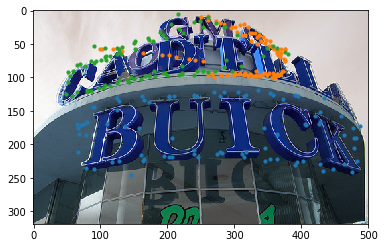

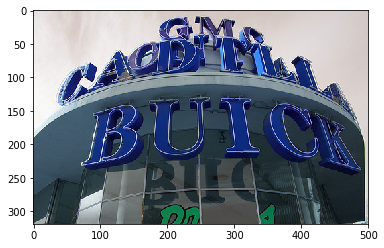

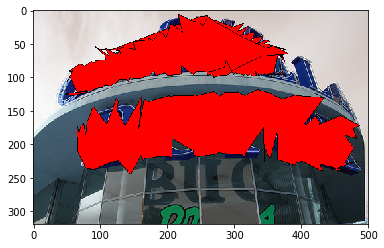

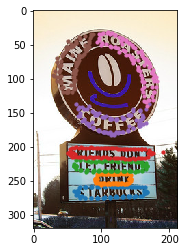

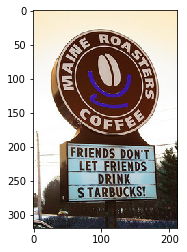

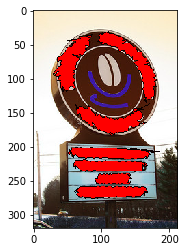

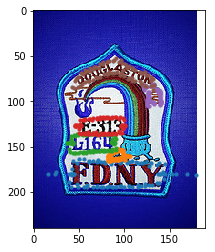

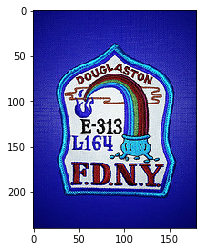

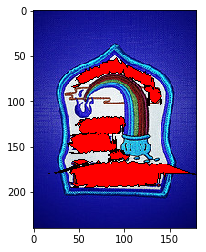

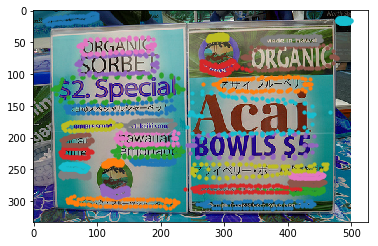

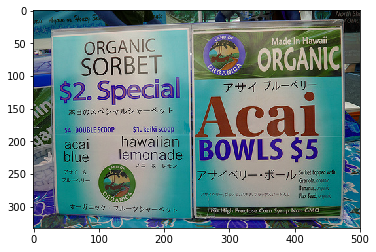

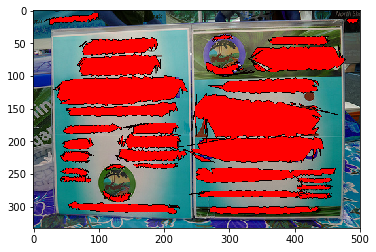

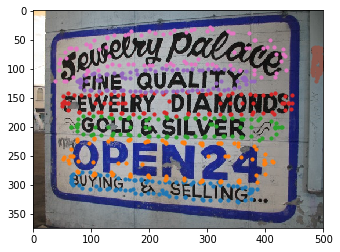

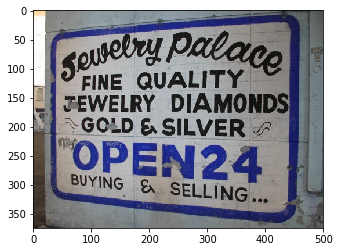

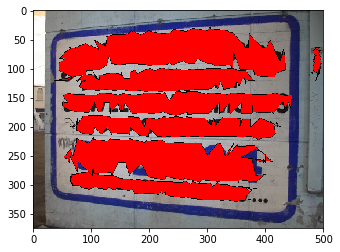

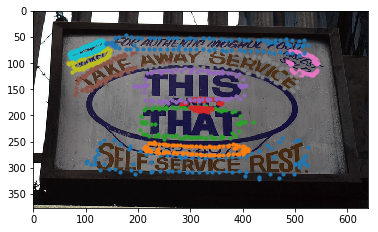

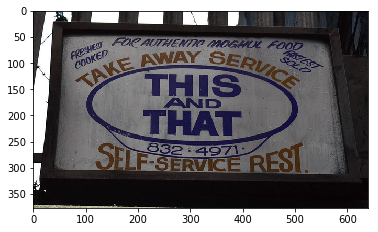

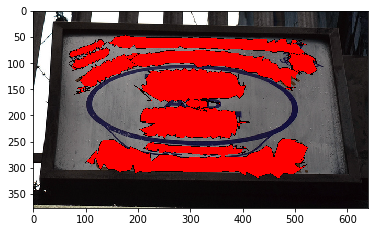

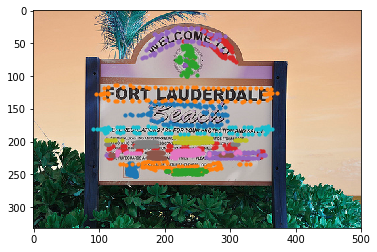

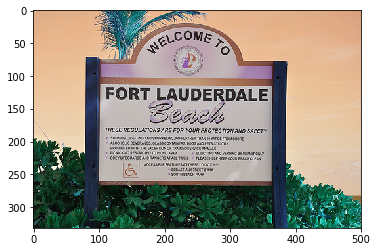

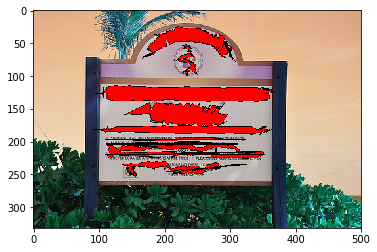

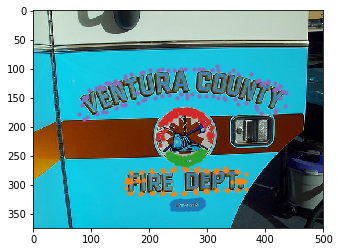

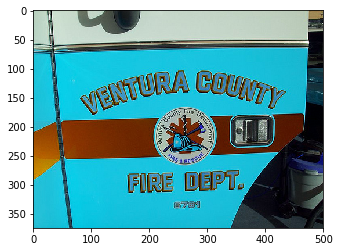

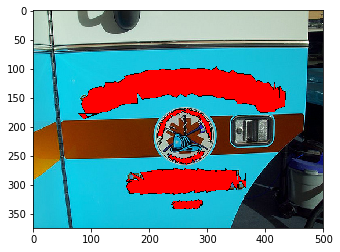

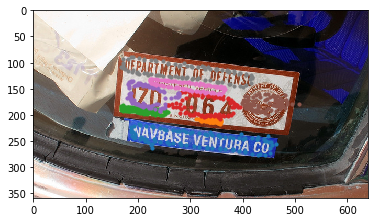

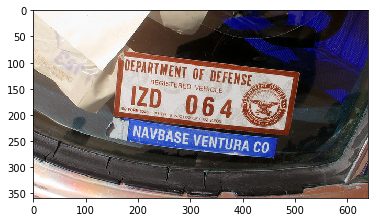

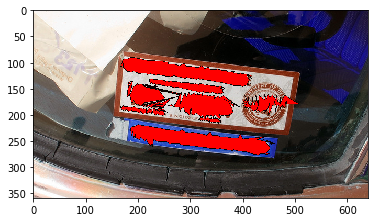

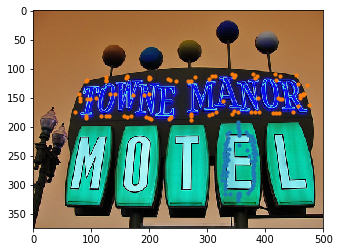

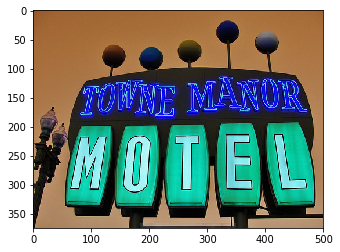

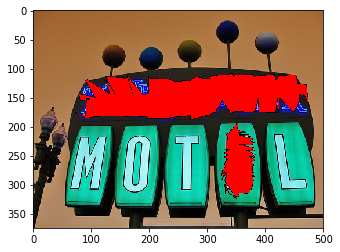

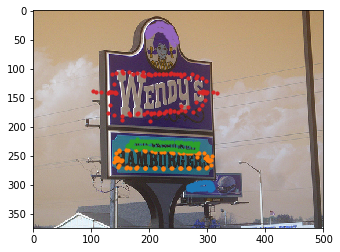

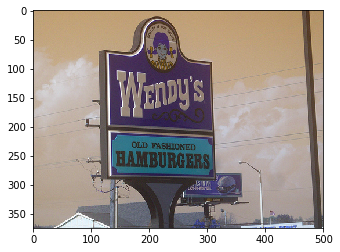

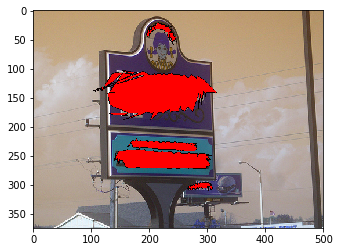

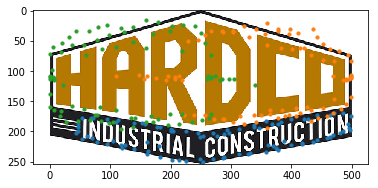

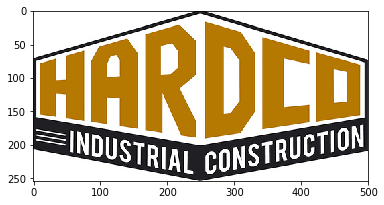

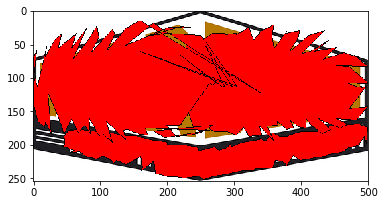

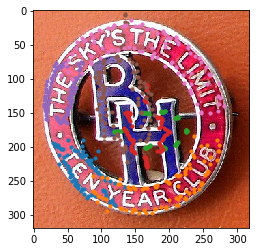

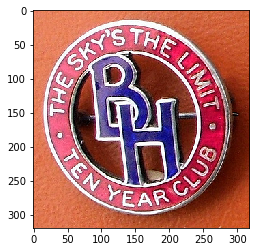

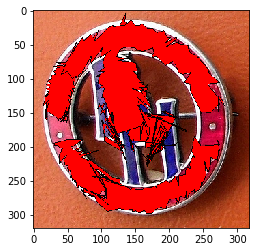

In [7]:
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as Patches

mat_path = 'mat'

for roots, dirs, files in os.walk(mat_path):
    for f in files:
        print ('deal file {}'.format(f))
        allOutputPolyPoints =[]
        mat_name = f[:-4]
        data = scio.loadmat(os.path.join(mat_path, f))
        text_region = data['text_region']
        skeleton = data['skeleton']
        dir_maps = data['dir']
        ratio_h = data['ratio_h']
        ratio_w = data['ratio_w']
        
        [map_h,map_w,_] = dir_maps.shape
        
        img_name = '../datasets/ctw_test500/'+mat_name+'.jpg'
        img = cv2.imread(img_name)
        
        img_to_show = Image.fromarray(img)
        draw = ImageDraw.Draw(img_to_show)
        plt.figure()
        plt.imshow(img)
        

        # skeleton聚类得到连通域
        skeleton_map, box_list, cat_list = getRedConnectedAndBorder(np.array(skeleton*255, dtype=np.uint8))
        for idx, box in enumerate(box_list):
            # skeleton 采样得到中心点
            samplePoints = findSamplePoints(skeleton_map, box, cat_list[idx], 10)
            # 获取skeleton每个点的有效方向上的点和距离
            borderPoints, pointsDis = drawContour(skeleton_map, samplePoints, dir_maps)
            outputPolyPoints = getOutputPolyPoints(samplePoints, borderPoints, pointsDis, map_h, map_w, ratio_h, ratio_w)
            allOutputPolyPoints.append(outputPolyPoints)
            
            ###  for visualization ###
            outputPolyPointsArray = np.asarray(outputPolyPoints)
            outputPolyPointsArrayNew = np.copy(outputPolyPointsArray)
            outputPolyPointsArrayNew[:,0] = outputPolyPointsArray[:,1]/ratio_w
            outputPolyPointsArrayNew[:,1] = outputPolyPointsArray[:,0]/ratio_h
            outputPolyPointsTuple = tuple(map(tuple, outputPolyPointsArrayNew))
            plt.scatter(outputPolyPointsArrayNew[:,0], outputPolyPointsArrayNew[:,1],10)
            draw.polygon(outputPolyPointsTuple, outline = 10, fill = 'red')

        plt.figure()
        plt.imshow (img)
        plt.figure()
        plt.imshow(img_to_show)